# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

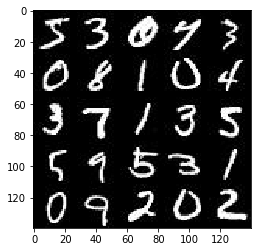

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

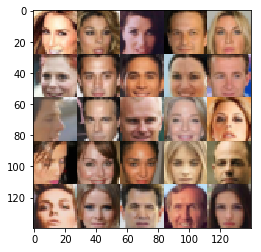

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_images = tf.placeholder(tf.float32, 
                                    shape=(None, image_width, image_height, image_channels),
                                    name='input_images')
    
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return input_images, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [173]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    sigma = 0.02

    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28
        x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same',
                                kernel_initializer = tf.random_normal_initializer(stddev=sigma))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = leaky_relu(x1)
        
        # 14x14
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                            kernel_initializer = tf.random_normal_initializer(stddev=sigma))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2)

        # 7x7
        x3 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='valid',
                            kernel_initializer = tf.random_normal_initializer(stddev=sigma))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3)

        flat = tf.reshape(x3, (-1, 3*3*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
     
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [172]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    sigma = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 3*3*256)
        x1 = tf.reshape(x1, (-1, 3, 3, 256))
        x1 = leaky_relu(x1)
        
        # 7x7
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='valid',
                    kernel_initializer = tf.random_normal_initializer(stddev=sigma))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        
        # 14x14
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',
                    kernel_initializer = tf.random_normal_initializer(stddev=sigma))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)

        # 28x28
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5,
                    strides=2, padding='same',
                    kernel_initializer = tf.random_normal_initializer(stddev=sigma))
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [160]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [157]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [141]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [142]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = out_channel_dim = data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print('Epoch: {}'.format(epoch_i))
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                input_z: batch_z,
                                                learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                learn_rate: learning_rate})
                               
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim,
                                          data_image_mode)
                    
                    d_l = sess.run(d_loss, feed_dict={input_real: batch_images,
                                                  input_z: batch_z})
                    g_l = sess.run(g_loss, feed_dict={input_z: batch_z})
                    print('loss of generator: {}'.format(d_l))
                    print('loss of discriminator: {}'.format(g_l))
                    
        print("Train finished")
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0


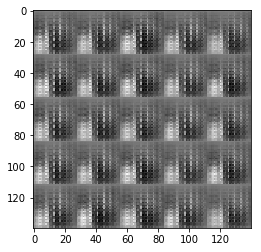

loss of generator: 0.5174241662025452
loss of discriminator: 2.2000324726104736


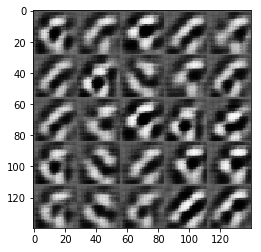

loss of generator: 1.090598225593567
loss of discriminator: 1.5193395614624023


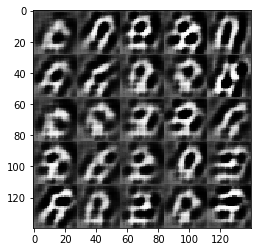

loss of generator: 0.9739660620689392
loss of discriminator: 1.3034312725067139


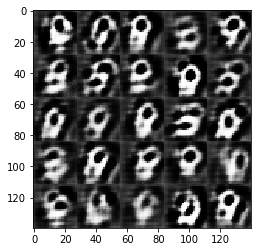

loss of generator: 0.9225879907608032
loss of discriminator: 1.2428114414215088


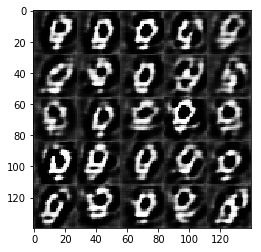

loss of generator: 0.9646008014678955
loss of discriminator: 1.3935574293136597


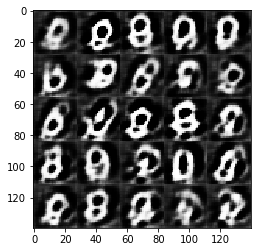

loss of generator: 1.123035192489624
loss of discriminator: 1.0758955478668213


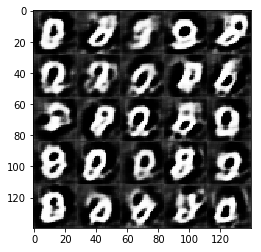

loss of generator: 0.9363894462585449
loss of discriminator: 1.6460374593734741


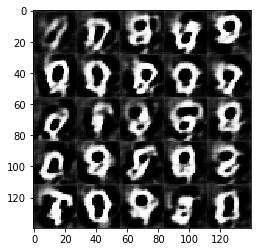

loss of generator: 1.2072738409042358
loss of discriminator: 0.7588640451431274


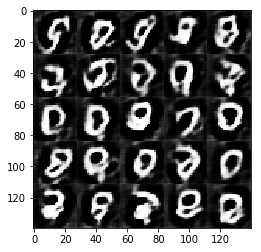

loss of generator: 1.2266925573349
loss of discriminator: 0.7992261052131653
Epoch: 1


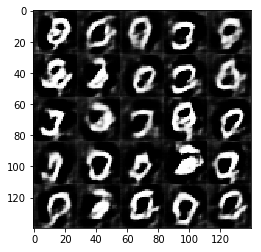

loss of generator: 1.000143051147461
loss of discriminator: 1.376465916633606


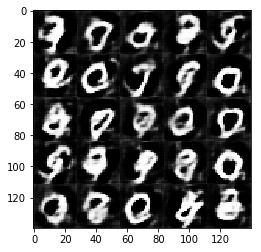

loss of generator: 1.2140583992004395
loss of discriminator: 1.0636041164398193


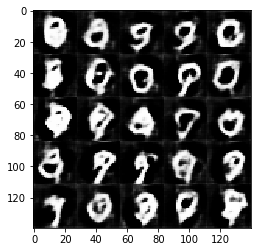

loss of generator: 0.9824099540710449
loss of discriminator: 1.0846179723739624


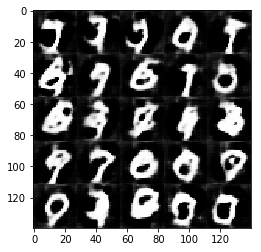

loss of generator: 1.5835518836975098
loss of discriminator: 0.870902419090271


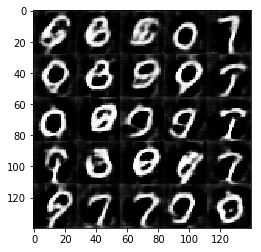

loss of generator: 1.1992905139923096
loss of discriminator: 0.9848071336746216


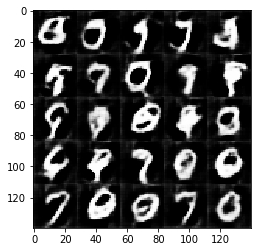

loss of generator: 1.1051278114318848
loss of discriminator: 1.14452064037323


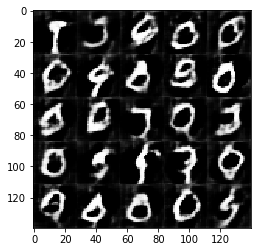

loss of generator: 1.1288926601409912
loss of discriminator: 0.9582780003547668


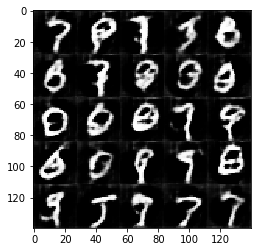

loss of generator: 1.1012630462646484
loss of discriminator: 1.693995475769043


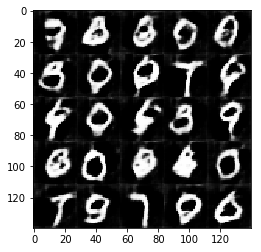

loss of generator: 1.0228196382522583
loss of discriminator: 1.1417186260223389
Train finished


In [177]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0


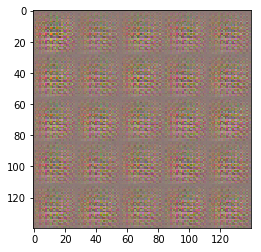

loss of generator: 0.916288435459137
loss of discriminator: 1.3557089567184448


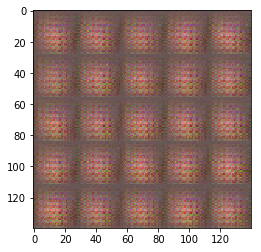

loss of generator: 0.7494054436683655
loss of discriminator: 1.4834293127059937


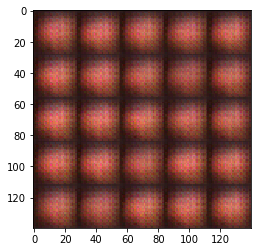

loss of generator: 0.8287642002105713
loss of discriminator: 1.5660996437072754


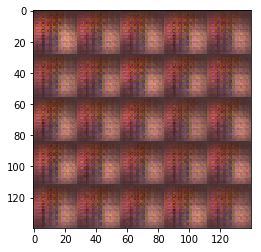

loss of generator: 0.6575455665588379
loss of discriminator: 1.8858706951141357


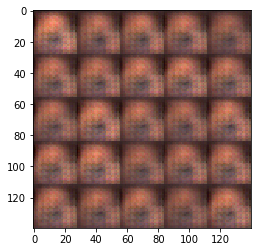

loss of generator: 0.8074137568473816
loss of discriminator: 1.6276979446411133


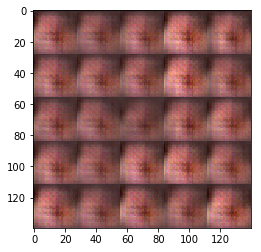

loss of generator: 0.7609403133392334
loss of discriminator: 1.7138152122497559


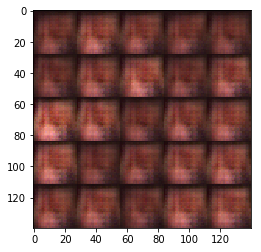

loss of generator: 0.7769393920898438
loss of discriminator: 1.59292471408844


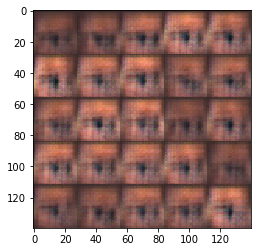

loss of generator: 0.7170077562332153
loss of discriminator: 1.7155553102493286


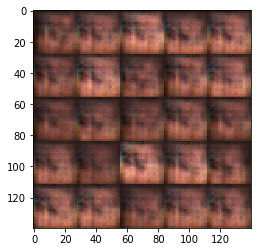

loss of generator: 0.7439042329788208
loss of discriminator: 1.6915557384490967


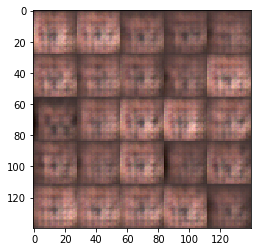

loss of generator: 0.7651650905609131
loss of discriminator: 1.505307674407959


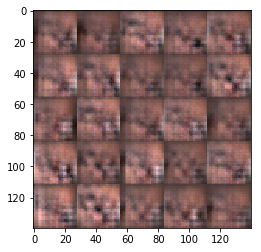

loss of generator: 0.7748768329620361
loss of discriminator: 1.5226826667785645


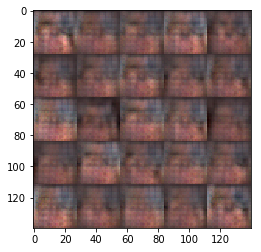

loss of generator: 0.8766652345657349
loss of discriminator: 1.4459364414215088


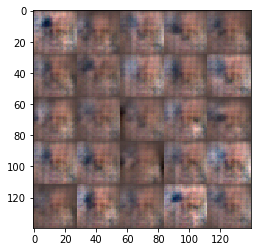

loss of generator: 0.858119010925293
loss of discriminator: 1.4595117568969727


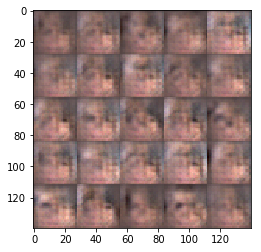

loss of generator: 0.9146786332130432
loss of discriminator: 1.3361879587173462


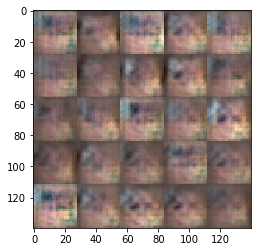

loss of generator: 0.8178203105926514
loss of discriminator: 1.4860799312591553


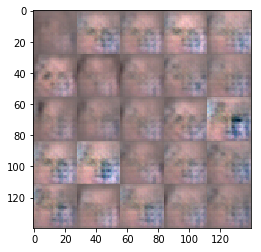

loss of generator: 0.9800752401351929
loss of discriminator: 1.2056471109390259


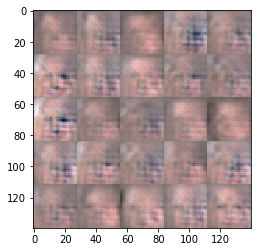

loss of generator: 0.9223333597183228
loss of discriminator: 1.4208980798721313


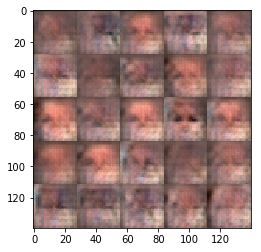

loss of generator: 0.9217641353607178
loss of discriminator: 1.356919527053833


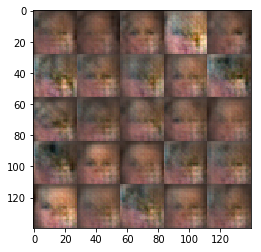

loss of generator: 0.892478346824646
loss of discriminator: 1.4247781038284302


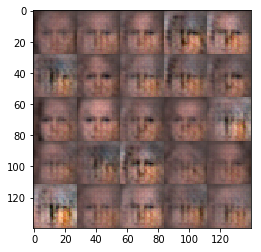

loss of generator: 0.8736189603805542
loss of discriminator: 1.4144943952560425


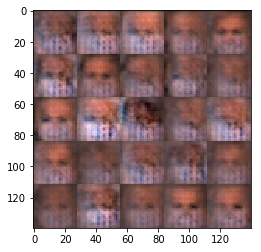

loss of generator: 0.948533833026886
loss of discriminator: 1.4680532217025757


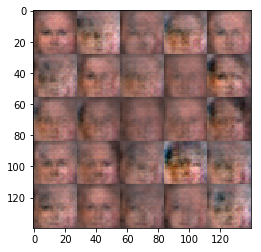

loss of generator: 0.9001078605651855
loss of discriminator: 1.3447811603546143


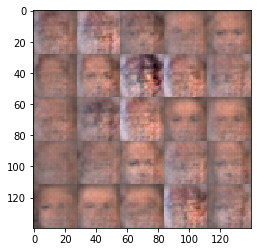

loss of generator: 0.8164928555488586
loss of discriminator: 1.4994900226593018


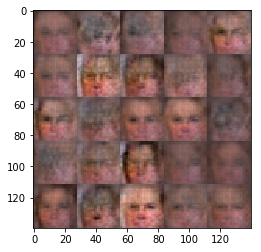

loss of generator: 1.033272624015808
loss of discriminator: 1.1707884073257446


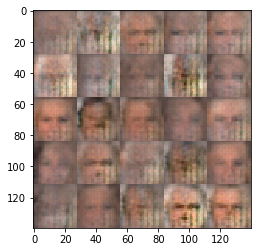

loss of generator: 0.9706772565841675
loss of discriminator: 1.3056886196136475


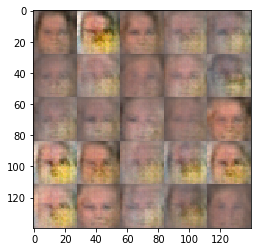

loss of generator: 0.9349815249443054
loss of discriminator: 1.300716519355774


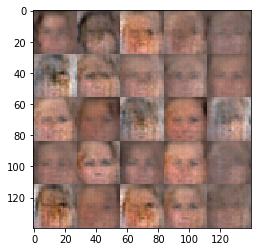

loss of generator: 0.98134845495224
loss of discriminator: 1.4001479148864746


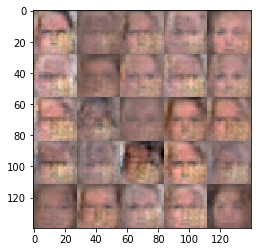

loss of generator: 1.0841083526611328
loss of discriminator: 1.2266987562179565


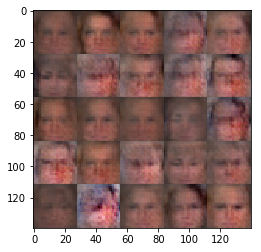

loss of generator: 1.1660451889038086
loss of discriminator: 1.186896562576294


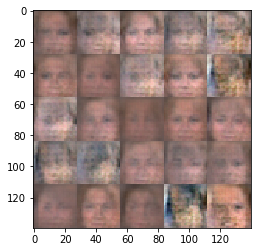

loss of generator: 0.9931358098983765
loss of discriminator: 1.2443374395370483


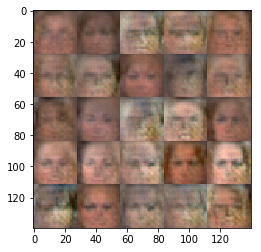

loss of generator: 1.1522163152694702
loss of discriminator: 1.094629168510437


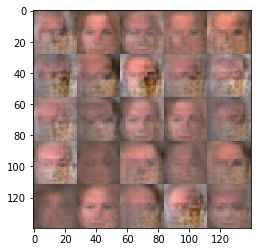

loss of generator: 1.0308961868286133
loss of discriminator: 1.3888481855392456


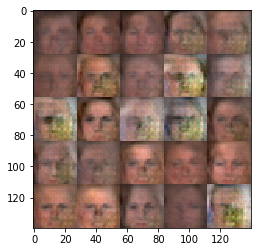

loss of generator: 1.0453351736068726
loss of discriminator: 1.1635777950286865


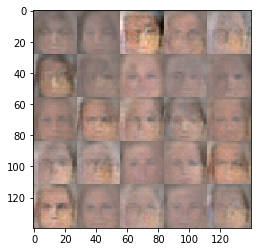

loss of generator: 1.0771818161010742
loss of discriminator: 1.1119952201843262


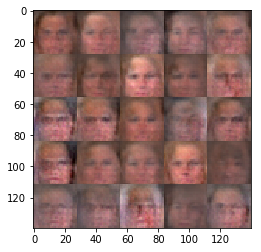

loss of generator: 1.2103798389434814
loss of discriminator: 0.9914757609367371


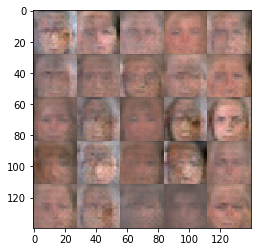

loss of generator: 1.1618627309799194
loss of discriminator: 0.998462975025177


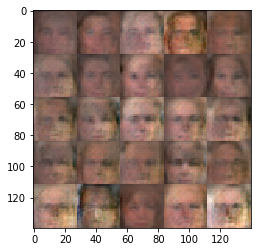

loss of generator: 1.0552027225494385
loss of discriminator: 1.2336946725845337


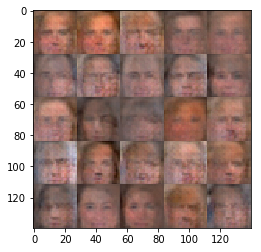

loss of generator: 1.1036677360534668
loss of discriminator: 1.1397371292114258


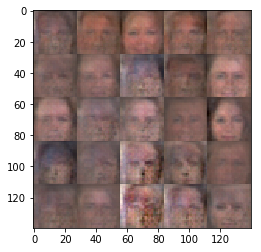

loss of generator: 0.9920778870582581
loss of discriminator: 1.215431571006775


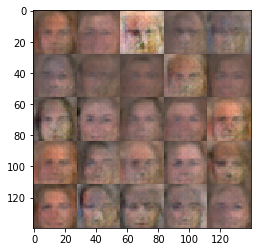

loss of generator: 1.0546132326126099
loss of discriminator: 1.219376802444458


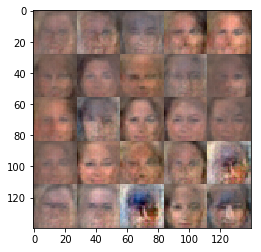

loss of generator: 1.205194115638733
loss of discriminator: 1.085764765739441


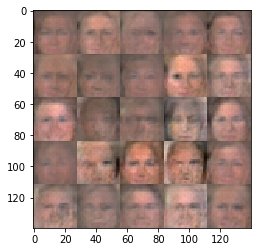

loss of generator: 1.135686993598938
loss of discriminator: 1.144471526145935


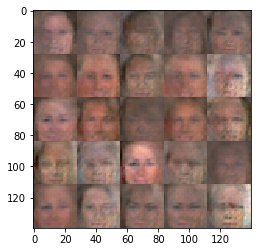

loss of generator: 1.0586540699005127
loss of discriminator: 1.16192626953125


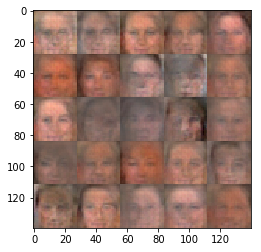

loss of generator: 1.0815305709838867
loss of discriminator: 1.1224764585494995


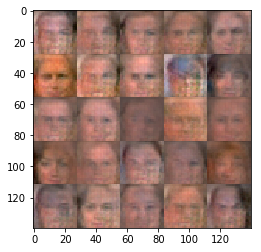

loss of generator: 1.1928014755249023
loss of discriminator: 1.04203462600708


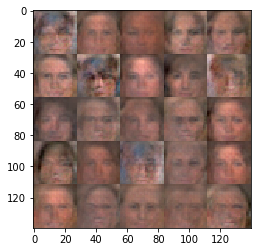

loss of generator: 1.170607566833496
loss of discriminator: 1.1708709001541138


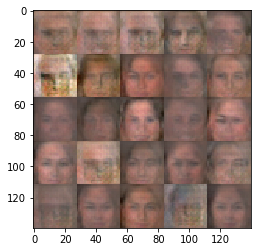

loss of generator: 1.14882230758667
loss of discriminator: 1.0519661903381348


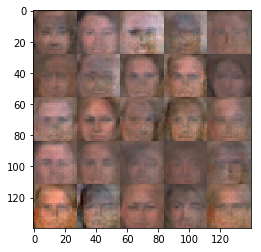

loss of generator: 1.0299217700958252
loss of discriminator: 1.208650827407837


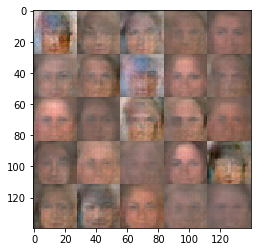

loss of generator: 1.054907202720642
loss of discriminator: 1.2648202180862427


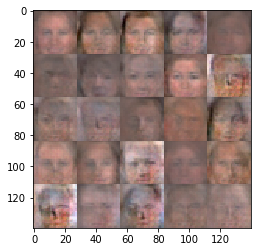

loss of generator: 1.0366735458374023
loss of discriminator: 1.1493533849716187


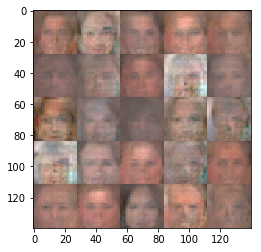

loss of generator: 1.1296995878219604
loss of discriminator: 1.0642950534820557


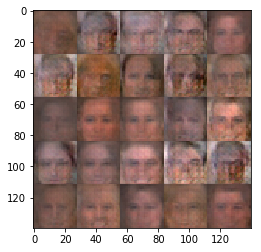

loss of generator: 1.1510730981826782
loss of discriminator: 1.1792547702789307


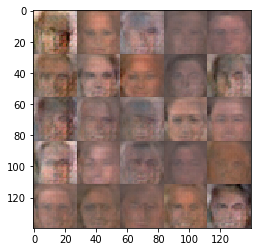

loss of generator: 0.9475716352462769
loss of discriminator: 1.3912537097930908


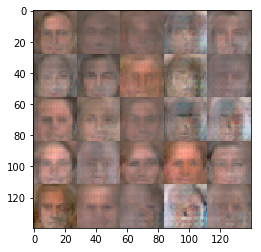

loss of generator: 1.099015712738037
loss of discriminator: 1.2078644037246704


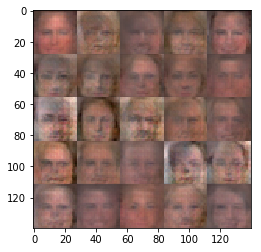

loss of generator: 1.1175936460494995
loss of discriminator: 1.007135033607483


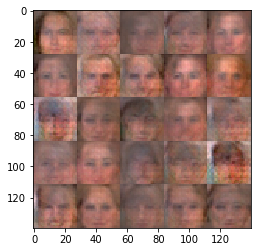

loss of generator: 1.0115565061569214
loss of discriminator: 1.1731795072555542


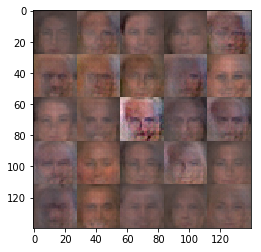

loss of generator: 1.154346227645874
loss of discriminator: 1.154642105102539


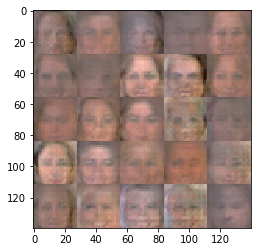

loss of generator: 1.0868656635284424
loss of discriminator: 1.1598652601242065


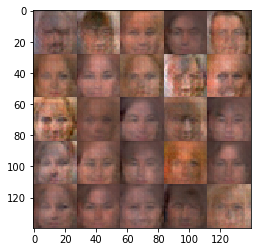

loss of generator: 1.0816872119903564
loss of discriminator: 1.110417127609253


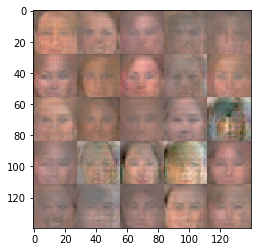

loss of generator: 1.1794030666351318
loss of discriminator: 0.9080743193626404


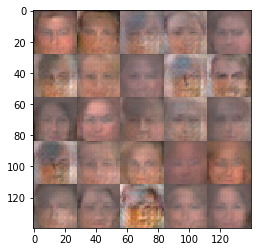

loss of generator: 1.2395660877227783
loss of discriminator: 0.9492354989051819


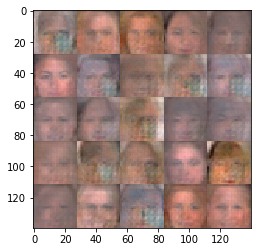

loss of generator: 1.1321895122528076
loss of discriminator: 1.0657604932785034


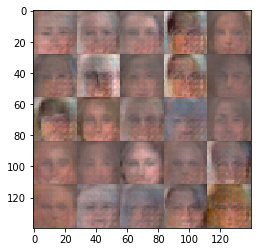

loss of generator: 1.0760986804962158
loss of discriminator: 1.1134551763534546
Train finished


In [191]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.